<a href="https://colab.research.google.com/github/zsajadifar/P-D-Information-Systems-and-Signal-Processing/blob/main/convolutional_baseline_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load required libraries
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation
from keras import regularizers
import tensorflow as tf 
from tensorflow.python.ops.linalg_ops import norm
import h5py
import numpy as np
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
time_window = 640;
eeg = tf.keras.layers.Input(shape=[time_window, 64])
env1 = tf.keras.layers.Input(shape=[time_window, 1])
env2 = tf.keras.layers.Input(shape=[time_window, 1])

#add model layers
## ---- add your code ----here
filters = 1
kernel_size = 16
eeg_conv = tf.keras.layers.Conv1D(filters, kernel_size=kernel_size)(eeg)
cos1 = tf.keras.layers.Dot(1,normalize= True)([eeg_conv , env1[:,:-(kernel_size-1),:]])
cos2 = tf.keras.layers.Dot(1,normalize= True)([eeg_conv , env2[:,:-(kernel_size-1),:]])

# Classification
cos_similarity = tf.keras.layers.Concatenate()([cos1, cos2])
cos_flat = tf.keras.layers.Flatten()(cos_similarity)
out1 = tf.keras.layers.Dense(1, activation="sigmoid")(cos_flat)

# 1 output per batch
#out = tf.keras.layers.Reshape([1], name=output_name)(out1)
model = tf.keras.Model(inputs=[eeg, env1, env2], outputs=[out1])


In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 64)]    0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 640, 1)]     0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 640, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 625, 1)       1025        ['input_1[0][0]']                
                                                                                              

In [5]:
def batch_equalizer(eeg, env1, env2, labels):
    # present each of the eeg segments twice, where the envelopes, and thus the labels 
    # are swapped around. EEG presented in small segments [bs, window_length, 64]
    return np.concatenate([eeg,eeg], axis=0), np.concatenate([env1, env2], axis=0),np.concatenate([env2, env1], axis=0), np.concatenate([labels, (labels+1)%2], axis=0)


In [6]:
eeg_path = '/content/drive/MyDrive/Colab Notebooks/P&D_phase2/data/modified data/eeg_data.mat'
env_attend_path = '/content/drive/MyDrive/Colab Notebooks/P&D_phase2/data/modified data/env1_data.mat'
env_unattend_path = '/content/drive/MyDrive/Colab Notebooks/P&D_phase2/data/modified data/env2_data.mat'

In [7]:
from scipy.io import loadmat

eeg  = loadmat(eeg_path);
env1 = loadmat(env_attend_path)
env2 = loadmat(env_unattend_path)
eeg = eeg['eeg_data']
env1 = env1['env1_data']
env2 = env2['env2_data']

In [8]:
print(eeg.shape)
print(env1.shape)
print(env2.shape)

(8700, 640, 64)
(8700, 640, 1)
(8700, 640, 1)


In [9]:
p = 5
labels = np.zeros((1740*p,1))
eeg,env1,env2, labels = batch_equalizer(eeg, env1, env2, labels)


In [10]:
print(eeg.shape)
print(env1.shape)
print(env2.shape)
print(labels.shape)

(17400, 640, 64)
(17400, 640, 1)
(17400, 640, 1)
(17400, 1)


In [11]:
model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
      metrics=["acc"],
      loss=["binary_crossentropy"])

history = model.fit([eeg, env1, env2], labels,batch_size=64,
          epochs=500,validation_split=0.2,shuffle=True,
          verbose=2)
          

Epoch 1/500
218/218 - 19s - loss: 0.6657 - acc: 0.6241 - val_loss: 0.9642 - val_acc: 0.0000e+00 - 19s/epoch - 87ms/step
Epoch 2/500
218/218 - 3s - loss: 0.6630 - acc: 0.6238 - val_loss: 0.8859 - val_acc: 2.8736e-04 - 3s/epoch - 14ms/step
Epoch 3/500
218/218 - 3s - loss: 0.6595 - acc: 0.6224 - val_loss: 1.0593 - val_acc: 0.0046 - 3s/epoch - 14ms/step
Epoch 4/500
218/218 - 3s - loss: 0.6558 - acc: 0.6232 - val_loss: 1.0242 - val_acc: 0.0118 - 3s/epoch - 14ms/step
Epoch 5/500
218/218 - 3s - loss: 0.6523 - acc: 0.6280 - val_loss: 1.0196 - val_acc: 0.0460 - 3s/epoch - 14ms/step
Epoch 6/500
218/218 - 3s - loss: 0.6498 - acc: 0.6275 - val_loss: 1.0098 - val_acc: 0.0477 - 3s/epoch - 14ms/step
Epoch 7/500
218/218 - 3s - loss: 0.6483 - acc: 0.6302 - val_loss: 0.9632 - val_acc: 0.0724 - 3s/epoch - 14ms/step
Epoch 8/500
218/218 - 3s - loss: 0.6477 - acc: 0.6294 - val_loss: 1.0097 - val_acc: 0.0899 - 3s/epoch - 14ms/step
Epoch 9/500
218/218 - 3s - loss: 0.6458 - acc: 0.6305 - val_loss: 0.9029 - val

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


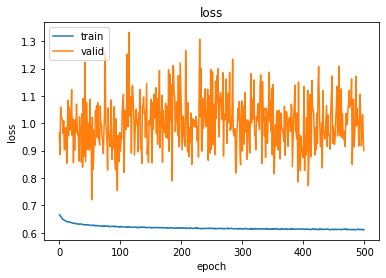

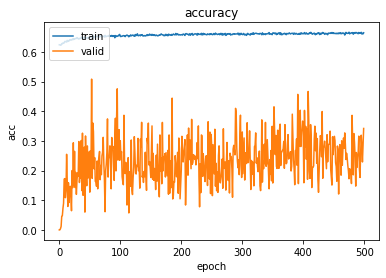

In [12]:
print(history.history.keys())

#plt.subplot(1,2,1)        
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.ylabel('acc')  
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
